In [1]:
import os
os.chdir('/app')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
print("Libraries loaded successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully
Pandas version: 2.1.4
NumPy version: 1.26.3


In [2]:
# Load raw dataset
df = pd.read_csv('data/raw_listings.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:\n{df.dtypes}")
print(f"First 5 rows:")
df.head()

Dataset shape: (628, 9)

Column types:
location          object
property_type     object
bedrooms           int64
bathrooms          int64
size_sqft        float64
amenities         object
price_kes        float64
listing_date      object
source            object
dtype: object
First 5 rows:


,location,property_type,bedrooms,bathrooms,size_sqft,amenities,price_kes,listing_date,source
0,Kileleshwa,Apartment,1,1,0.00,NaN,"57,000,001.00",2026-02-17,jiji.co.ke
1,Kilimani,Apartment,3,2,"1,614.60",NaN,"108,000,003.00",2026-02-17,jiji.co.ke
2,Kileleshwa,Apartment,3,2,0.00,Garden,"145,000,003.00",2026-02-17,jiji.co.ke
3,Nairobi,Other,2,1,"45,208.80",NaN,"1,500,000,002.00",2026-02-17,jiji.co.ke
4,Nairobi,Other,1,1,"45,208.80",NaN,"1,500,000,001.00",2026-02-17,jiji.co.ke


In [3]:
# Initial Data Exploration
print("--" * 60)
print("INITIAL DATA EXPLORATION")
print("--" * 60)

print(f"\nTotal records: {len(df)}")
print(f"\nMissing values per column:")
print(df.isnull().sum())

print(f"\nBasic Statistics:")
print(df.describe())

print(f"\nProperty types:")
print(df['property_type'].value_counts())

print(f"\nLocations:")
print(df['location'].value_counts().head(15))

------------------------------------------------------------------------------------------------------------------------
INITIAL DATA EXPLORATION
------------------------------------------------------------------------------------------------------------------------

Total records: 628

Missing values per column:
location           0
property_type      0
bedrooms           0
bathrooms          0
size_sqft          0
amenities        561
price_kes          0
listing_date       0
source             0
dtype: int64

Basic Statistics:
       bedrooms  bathrooms  size_sqft         price_kes
count    628.00     628.00     628.00            628.00
mean      46.57      46.39   5,384.04    506,534,847.33
std      644.58     644.53  12,098.12  1,528,453,851.02
min        0.00       1.00       0.00        370,000.00
25%        0.00       1.00       0.00     45,000,000.75
50%        2.00       1.00     645.84    130,000,002.50
75%        4.00       3.00   3,234.58    372,500,001.00
max    9,994.00 

In [4]:
# Remove Duplicates
print(f"Records before deduplication: {len(df)}")

# Drop exact duplicates
df = df.drop_duplicates()

# Drop duplicates based on key fields
df = df.drop_duplicates(subset=['price_kes', 'location', 'bedrooms', 'property_type'])

print(f"Records after deduplication: {len(df)}")
print(f"Duplicates removed: {628 - len(df)}")

Records before deduplication: 628
Records after deduplication: 628
Duplicates removed: 0


In [5]:
print("HANDLING MISSING VALUES")
print("--" * 60)

# 1. Replace 0.0 size_sqft with NaN (0 means missing, not actual 0)
df['size_sqft'] = df['size_sqft'].replace(0.0, np.nan)
print(f"Missing size_sqft: {df['size_sqft'].isna().sum()}")

# 2. Fill missing size_sqft with median per property type
df['size_sqft'] = df.groupby('property_type')['size_sqft'].transform(
    lambda x: x.fillna(x.median())
)

# 3. Fill any remaining missing size_sqft with overall median
df['size_sqft'] = df['size_sqft'].fillna(df['size_sqft'].median())

# 4. Fill empty amenities with 'None'
df['amenities'] = df['amenities'].fillna('').replace('', 'None')

print(f"\nMissing values after handling:")
print(df.isnull().sum())

HANDLING MISSING VALUES
------------------------------------------------------------------------------------------------------------------------
Missing size_sqft: 294

Missing values after handling:
location         0
property_type    0
bedrooms         0
bathrooms        0
size_sqft        0
amenities        0
price_kes        0
listing_date     0
source           0
dtype: int64


In [6]:
# Standardize Location Names
print("STANDARDIZING LOCATION NAMES")
print("--" * 60)

# Location mapping
location_mapping = {
    'Nairobi Central': 'Nairobi CBD',
    'Nairobi': 'Nairobi Other',
    'Riverside Drive': 'Westlands',
    'Kahawa Sukari': 'Kasarani',
    'Kahawa': 'Kasarani',
    'Mlolongo': 'Syokimau',
    'Athi River': 'Athi River',
}

df['location'] = df['location'].replace(location_mapping)

# Locations assigned based on known sub-areas
print(f"\nLocation distribution after standardization:")
print(df['location'].value_counts().head(15))

STANDARDIZING LOCATION NAMES
------------------------------------------------------------------------------------------------------------------------

Location distribution after standardization:
location
Nairobi Other    177
Kasarani          72
Westlands         61
Nairobi CBD       61
Kilimani          39
Kileleshwa        33
Utawala           31
Lavington         30
Karen             22
Runda             19
Embakasi          16
Parklands         15
South C            8
Muthaiga           7
Langata            7
Name: count, dtype: int64


In [7]:
print("STANDARDIZING PROPERTY TYPES")
print("--" * 60)

# Reclassify "Other" based on bedrooms and size
def classify_property_type(row):
    if row['property_type'] != 'Other':
        return row['property_type']

    # Land/Plot classification
    if row['bedrooms'] == 0:
        return 'Plot'

    # Classify based on bedrooms
    if row['bedrooms'] <= 2:
        return 'Apartment'
    elif row['bedrooms'] <= 4:
        return 'House'
    else:
        return 'Mansion'

df['property_type'] = df.apply(classify_property_type, axis=1)

print(f"\nProperty types after standardization:")
print(df['property_type'].value_counts())

STANDARDIZING PROPERTY TYPES
------------------------------------------------------------------------------------------------------------------------

Property types after standardization:
property_type
Apartment     266
Plot          169
Maisonette     55
House          45
Land           26
Mansion        25
Villa          17
Bungalow       13
Townhouse      12
Name: count, dtype: int64


In [8]:
print("REMOVING EXTREME OUTLIERS")
print("--" * 60)

print(f"Records before outlier removal: {len(df)}")

# Price outliers - IQR method
Q1 = df['price_kes'].quantile(0.05)
Q3 = df['price_kes'].quantile(0.95)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nPrice bounds:")
print(f"   Lower: KES {lower_bound:,.0f}")
print(f"   Upper: KES {upper_bound:,.0f}")

# Filter out extreme outliers
df_clean = df[
    (df['price_kes'] >= lower_bound) &
    (df['price_kes'] <= upper_bound)
].copy()

# Remove unrealistic sizes
df_clean = df_clean[df_clean['size_sqft'] < 100000]

print(f"\nRecords after outlier removal: {len(df_clean)}")
print(f"Outliers removed: {len(df) - len(df_clean)}")

# Price stats after cleaning
print(f"\nPrice statistics after cleaning:")
print(df_clean['price_kes'].describe())

REMOVING EXTREME OUTLIERS
------------------------------------------------------------------------------------------------------------------------
Records before outlier removal: 628

Price bounds:
   Lower: KES -2,390,000,008
   Upper: KES 3,994,000,012

Records after outlier removal: 614
Outliers removed: 14

Price statistics after cleaning:
count             614.00
mean      313,524,240.95
std       523,439,794.23
min           370,000.00
25%        42,750,000.00
50%       130,000,000.00
75%       340,000,004.00
max     3,550,000,008.00
Name: price_kes, dtype: float64


In [9]:
print("FEATURE ENGINEERING")
print("--" * 60)

# 1. price_per_sqft
df_clean['price_per_sqft'] = df_clean['price_kes'] / df_clean['size_sqft']
df_clean['price_per_sqft'] = df_clean['price_per_sqft'].round(2)

# 2. amenity_score (count of amenities)
def count_amenities(amenities_str):
    if amenities_str == 'None' or not amenities_str:
        return 0
    return len([a.strip() for a in amenities_str.split(',') if a.strip()])

df_clean['amenity_score'] = df_clean['amenities'].apply(count_amenities)

# 3. month (from listing_date)
df_clean['listing_date'] = pd.to_datetime(df_clean['listing_date'])
df_clean['month'] = df_clean['listing_date'].dt.month
df_clean['month_name'] = df_clean['listing_date'].dt.strftime('%B')

# 4. Boolean amenity flags
df_clean['has_parking'] = df_clean['amenities'].str.lower().str.contains('parking').astype(int)
df_clean['has_pool'] = df_clean['amenities'].str.lower().str.contains('pool').astype(int)
df_clean['has_gym'] = df_clean['amenities'].str.lower().str.contains('gym').astype(int)
df_clean['has_security'] = df_clean['amenities'].str.lower().str.contains('security').astype(int)
df_clean['has_garden'] = df_clean['amenities'].str.lower().str.contains('garden').astype(int)

# 5. is_land flag
df_clean['is_land'] = df_clean['property_type'].isin(['Land', 'Plot']).astype(int)

print("New features created:")
print(f"  price_per_sqft: {df_clean['price_per_sqft'].describe()}")
print(f"\n  amenity_score distribution:")
print(df_clean['amenity_score'].value_counts().sort_index())
print(f"\n  Amenity flags:")
print(f"    has_parking: {df_clean['has_parking'].sum()}")
print(f"    has_pool: {df_clean['has_pool'].sum()}")
print(f"    has_gym: {df_clean['has_gym'].sum()}")
print(f"    has_security: {df_clean['has_security'].sum()}")
print(f"    has_garden: {df_clean['has_garden'].sum()}")

FEATURE ENGINEERING
------------------------------------------------------------------------------------------------------------------------
New features created:
  price_per_sqft: count       614.00
mean     56,453.06
std      82,306.77
min          10.74
25%       2,903.20
50%      22,460.27
75%      91,256.79
max     650,315.87
Name: price_per_sqft, dtype: float64

  amenity_score distribution:
amenity_score
0    548
1     55
2      7
3      2
4      2
Name: count, dtype: int64

  Amenity flags:
    has_parking: 4
    has_pool: 12
    has_gym: 12
    has_security: 7
    has_garden: 18


In [10]:
print("FINAL CLEAN DATASET")
print("--" * 60)

# Final column order
columns = [
    'location', 'property_type', 'bedrooms', 'bathrooms',
    'size_sqft', 'amenities', 'amenity_score',
    'has_parking', 'has_pool', 'has_gym', 'has_security', 'has_garden',
    'price_kes', 'price_per_sqft',
    'listing_date', 'month', 'month_name',
    'is_land', 'source'
]

df_clean = df_clean[columns].reset_index(drop=True)

print(f"Final shape: {df_clean.shape}")
print(f"\nColumn types:\n{df_clean.dtypes}")
print(f"\nMissing values:\n{df_clean.isnull().sum()}")
print(f"\nFirst 5 rows:")
df_clean.head()

FINAL CLEAN DATASET
------------------------------------------------------------------------------------------------------------------------
Final shape: (614, 19)

Column types:
location                  object
property_type             object
bedrooms                   int64
bathrooms                  int64
size_sqft                float64
amenities                 object
amenity_score              int64
has_parking                int64
has_pool                   int64
has_gym                    int64
has_security               int64
has_garden                 int64
price_kes                float64
price_per_sqft           float64
listing_date      datetime64[ns]
month                      int32
month_name                object
is_land                    int64
source                    object
dtype: object

Missing values:
location          0
property_type     0
bedrooms          0
bathrooms         0
size_sqft         0
amenities         0
amenity_score     0
has_parking       0
has

,location,property_type,bedrooms,bathrooms,size_sqft,amenities,amenity_score,has_parking,has_pool,has_gym,has_security,has_garden,price_kes,price_per_sqft,listing_date,month,month_name,is_land,source
0,Kileleshwa,Apartment,1,1,"1,614.60",None,0,0,0,0,0,0,"57,000,001.00","35,302.86",2026-02-17,2,February,0,jiji.co.ke
1,Kilimani,Apartment,3,2,"1,614.60",None,0,0,0,0,0,0,"108,000,003.00","66,889.63",2026-02-17,2,February,0,jiji.co.ke
2,Kileleshwa,Apartment,3,2,"1,614.60",Garden,1,0,0,0,0,1,"145,000,003.00","89,805.53",2026-02-17,2,February,0,jiji.co.ke
3,Nairobi Other,Apartment,2,1,"45,208.80",None,0,0,0,0,0,0,"1,500,000,002.00","33,179.38",2026-02-17,2,February,0,jiji.co.ke
4,Nairobi Other,Apartment,1,1,"45,208.80",None,0,0,0,0,0,0,"1,500,000,001.00","33,179.38",2026-02-17,2,February,0,jiji.co.ke


In [11]:
# Save to CSV
df_clean.to_csv('data/clean_listings.csv', index=False)
print(f"Saved clean_listings.csv with {len(df_clean)} records")
print(f"\nFile saved to: data/clean_listings.csv")

Saved clean_listings.csv with 614 records

File saved to: data/clean_listings.csv


BASIC EDA VISUALIZATIONS
------------------------------------------------------------------------------------------------------------------------


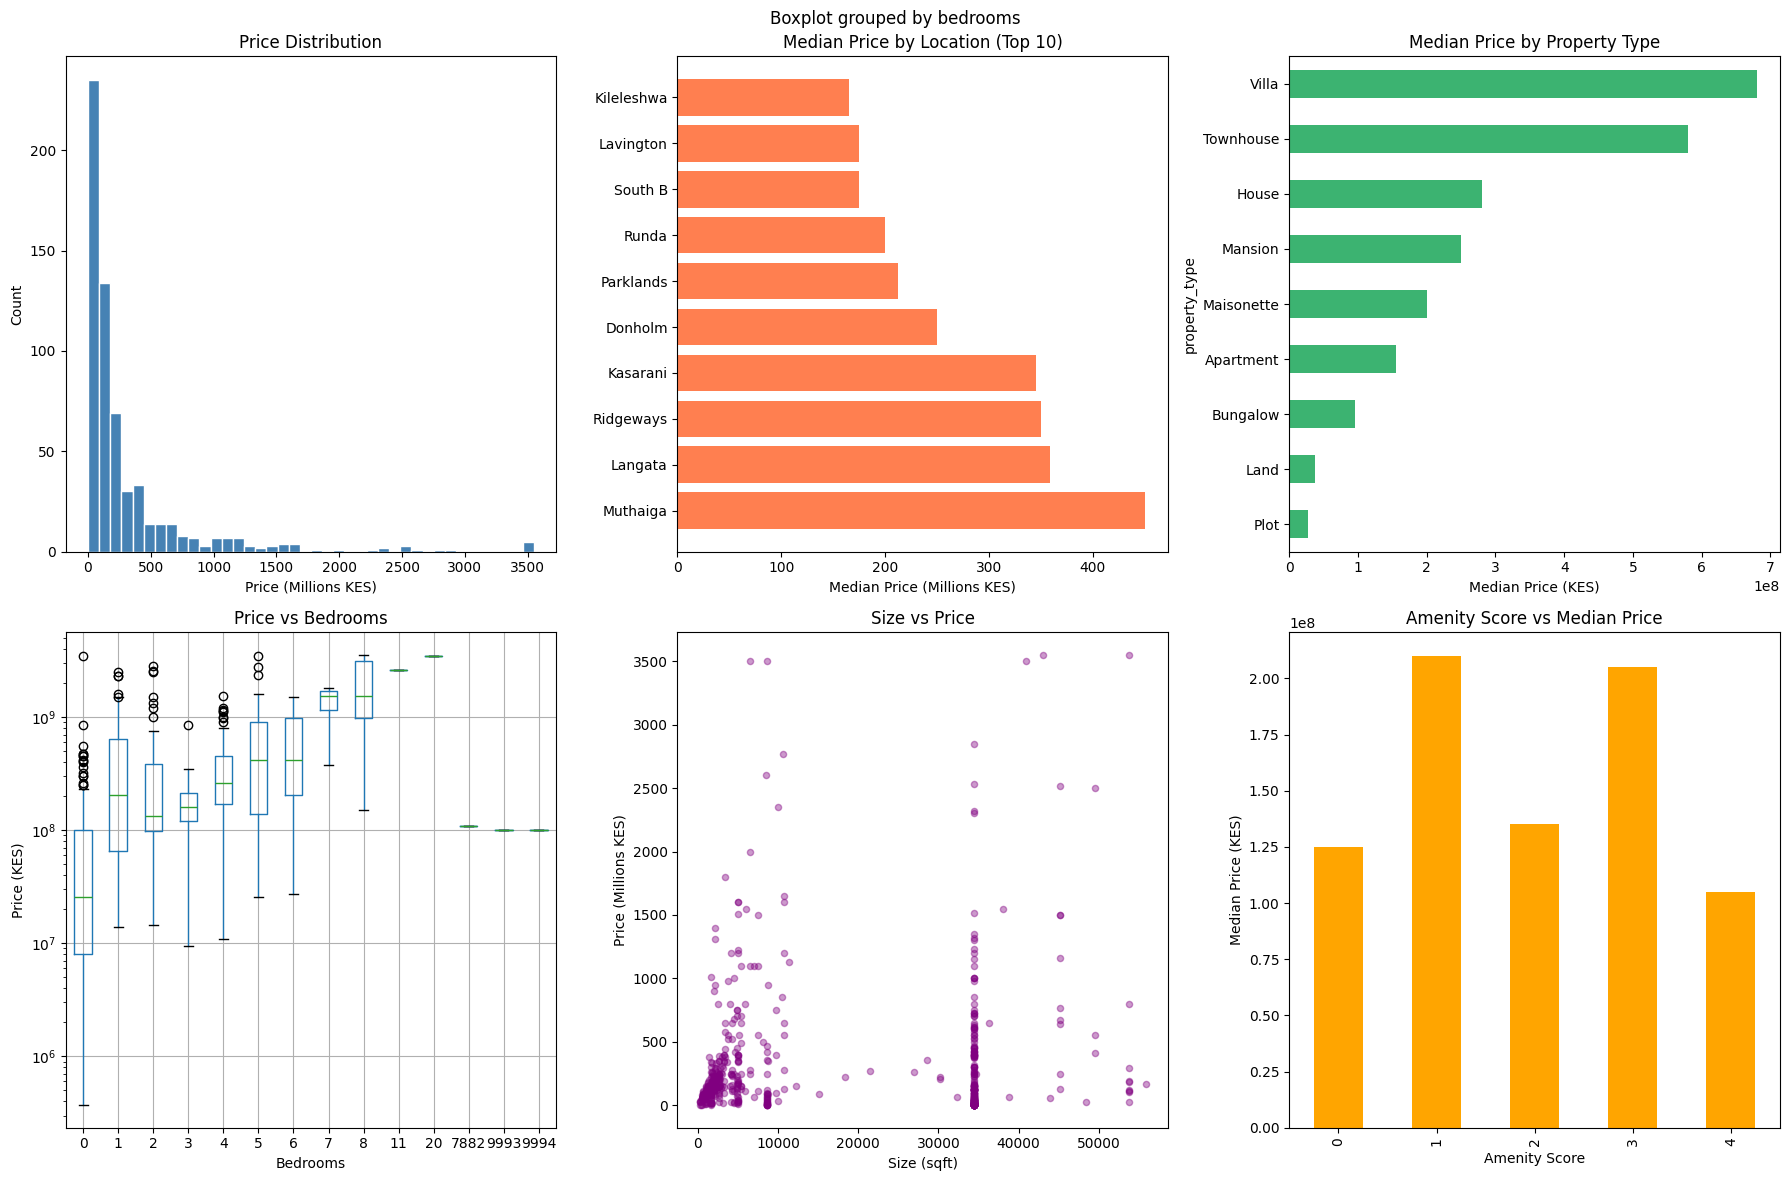

EDA visuals saved to data/eda_visuals.png


In [12]:
print("BASIC EDA VISUALIZATIONS")
print("--" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Nairobi House Price - Exploratory Data Analysis', fontsize=16, fontweight='bold')
# 1. Price Distribution
axes[0, 0].hist(df_clean['price_kes'] / 1e6, bins=40, color='steelblue', edgecolor='white')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (Millions KES)')
axes[0, 0].set_ylabel('Count')

# 2. Median Price by Location (Top 10)
top_locations = df_clean.groupby('location')['price_kes'].median().sort_values(ascending=False).head(10)
axes[0, 1].barh(top_locations.index, top_locations.values / 1e6, color='coral')
axes[0, 1].set_title('Median Price by Location (Top 10)')
axes[0, 1].set_xlabel('Median Price (Millions KES)')
# 3. Price by Property Type
df_clean.groupby('property_type')['price_kes'].median().sort_values().plot(
    kind='barh', ax=axes[0, 2], color='mediumseagreen'
)
axes[0, 2].set_title('Median Price by Property Type')
axes[0, 2].set_xlabel('Median Price (KES)')

# 4. Price vs Bedrooms
df_clean.boxplot(column='price_kes', by='bedrooms', ax=axes[1, 0])
axes[1, 0].set_title('Price vs Bedrooms')
axes[1, 0].set_xlabel('Bedrooms')
axes[1, 0].set_ylabel('Price (KES)')
plt.sca(axes[1, 0])
plt.yscale('log')

# 5. Size vs Price scatter
axes[1, 1].scatter(
    df_clean['size_sqft'], 
    df_clean['price_kes'] / 1e6,
    alpha=0.4, color='purple', s=20
)
axes[1, 1].set_title('Size vs Price')
axes[1, 1].set_xlabel('Size (sqft)')
axes[1, 1].set_ylabel('Price (Millions KES)')

# 6. Amenity Score vs Price
df_clean.groupby('amenity_score')['price_kes'].median().plot(
    kind='bar', ax=axes[1, 2], color='orange'
)
axes[1, 2].set_title('Amenity Score vs Median Price')
axes[1, 2].set_xlabel('Amenity Score')
axes[1, 2].set_ylabel('Median Price (KES)')
plt.tight_layout()
plt.savefig('data/eda_visuals.png', dpi=150, bbox_inches='tight')
plt.show()
print("EDA visuals saved to data/eda_visuals.png")

In [13]:
print("--" * 60)
print("DAY 2 SUMMARY REPORT")
print("EDA visuals saved to data/eda_visuals.png")

print(f"""
Raw Dataset:     {628} records
Clean Dataset:   {len(df_clean)} records
Records Removed: {628 - len(df_clean)} (duplicates + outliers)
Features Added:
  - price_per_sqft
  - amenity_score
  - month, month_name
  - has_parking, has_pool, has_gym, has_security, has_garden
  - is_land
Price Statistics (Clean Data):
  Min:    KES {df_clean['price_kes'].min():,.0f}
  Max:    KES {df_clean['price_kes'].max():,.0f}
  Mean:   KES {df_clean['price_kes'].mean():,.0f}
  Median: KES {df_clean['price_kes'].median():,.0f}
Top 5 Most Expensive Locations:
{df_clean.groupby('location')['price_kes'].median().sort_values(ascending=False).head(5).to_string()}
Files Saved:
  - data/clean_listings.csv
  - data/eda_visuals.png
""")

------------------------------------------------------------------------------------------------------------------------
DAY 2 SUMMARY REPORT
EDA visuals saved to data/eda_visuals.png

Raw Dataset:     628 records
Clean Dataset:   614 records
Records Removed: 14 (duplicates + outliers)
Features Added:
  - price_per_sqft
  - amenity_score
  - month, month_name
  - has_parking, has_pool, has_gym, has_security, has_garden
  - is_land
Price Statistics (Clean Data):
  Min:    KES 370,000
  Max:    KES 3,550,000,008
  Mean:   KES 313,524,241
  Median: KES 130,000,000
Top 5 Most Expensive Locations:
location
Muthaiga    450,000,000.00
Langata     359,000,004.00
Ridgeways   350,000,002.00
Kasarani    345,000,004.00
Donholm     250,000,003.00
Files Saved:
  - data/clean_listings.csv
  - data/eda_visuals.png

